In [1]:
import pandas as pd
import numpy as np
from utils import benchmark, report_plot

In [2]:
df = pd.read_csv('bio_train.csv', header=None)
y = df.iloc[:, 0].to_numpy()# block ids
X = df.iloc[:, 1:].to_numpy() # features


In [3]:
k = np.unique(y).size # amount unique block ids

In [4]:
report = {}
runs = 5
max_iter = 100
atol = 100

In [ ]:
lyod_title = 'Lyod\'s Algorithm'
report[lyod_title] = benchmark(X, y, k, runs, max_iter, atol, method='lyod', title=lyod_title)

In [ ]:
for bands in 1,:
    for buckets in 1,:
        lsh_title = f'Locality Sensitive Hashing - bands={bands}; buckets={buckets}'
        # report[lsh_title] = benchmark(X, y, k, 5, method='lsh', title=lsh_title, bands=bands, buckets=buckets)
        report[lsh_title] = benchmark(X, y, k, runs, max_iter, atol, method='lyod', title=lsh_title, bands=bands, buckets=buckets)

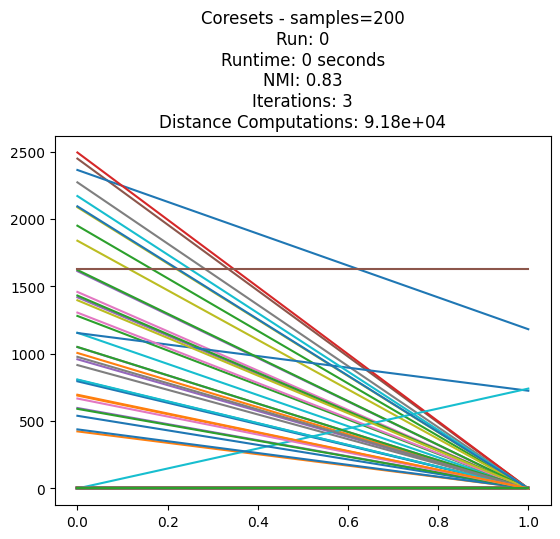

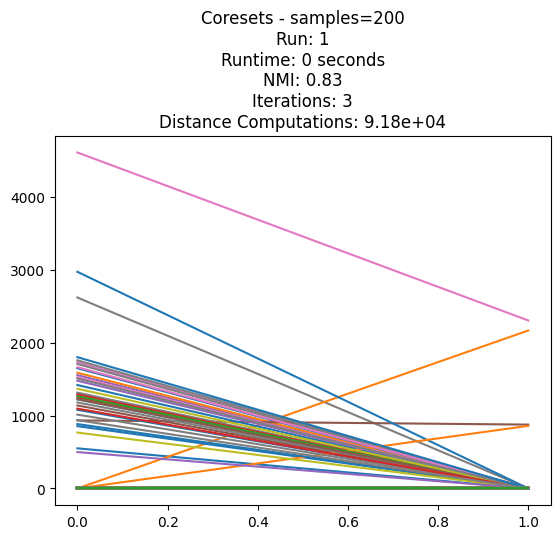

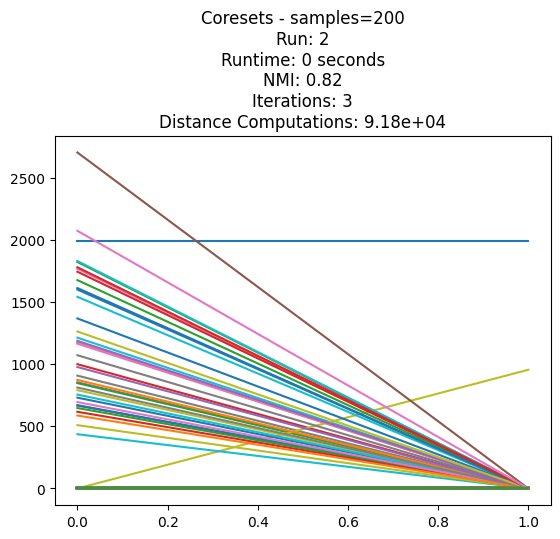

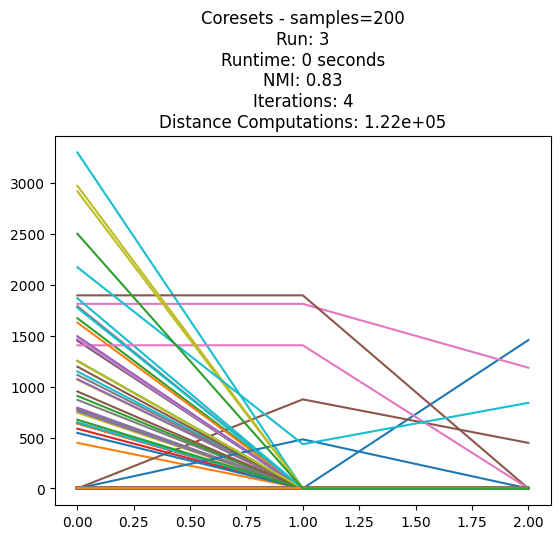

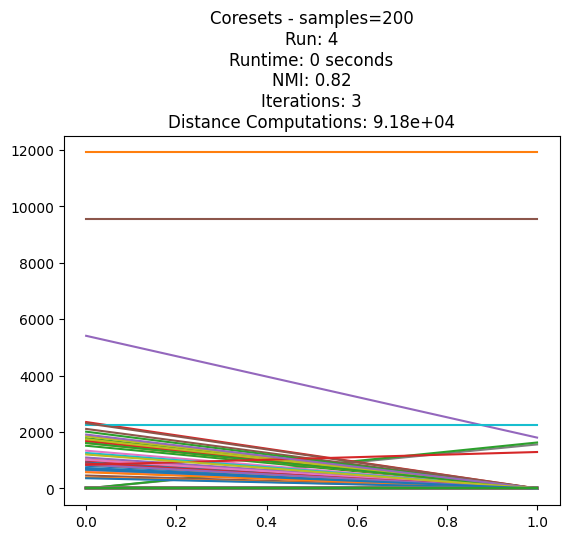

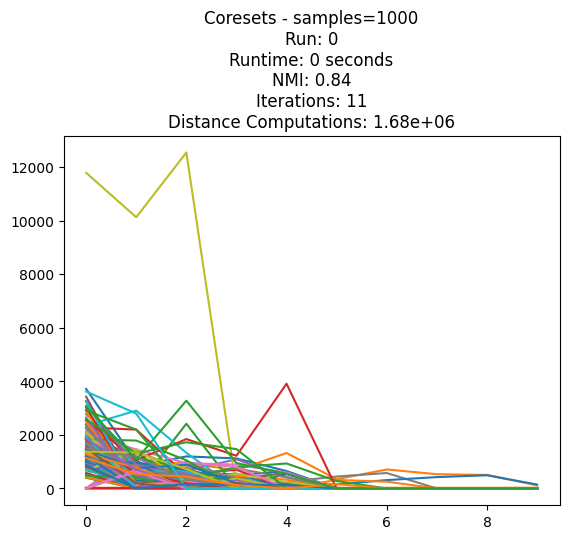

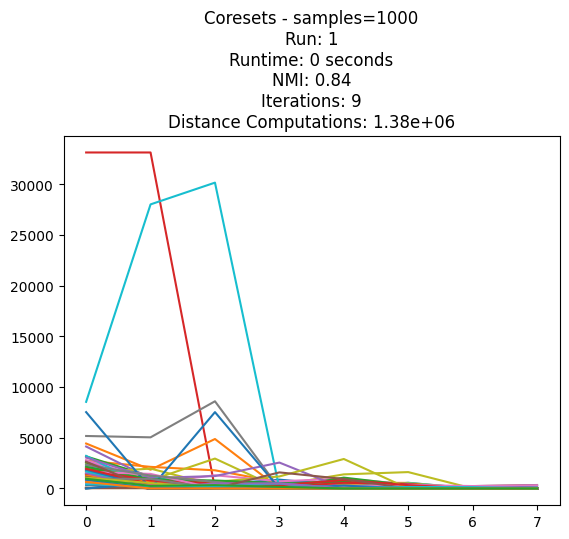

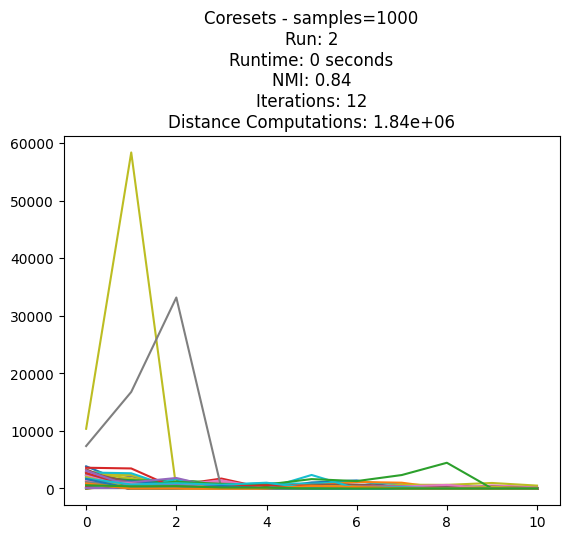

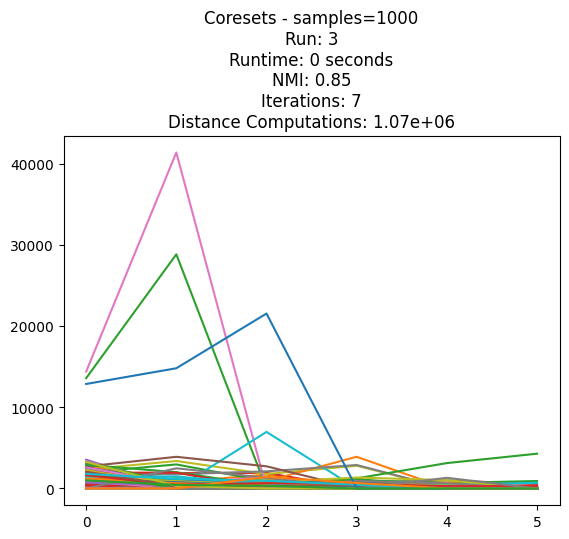

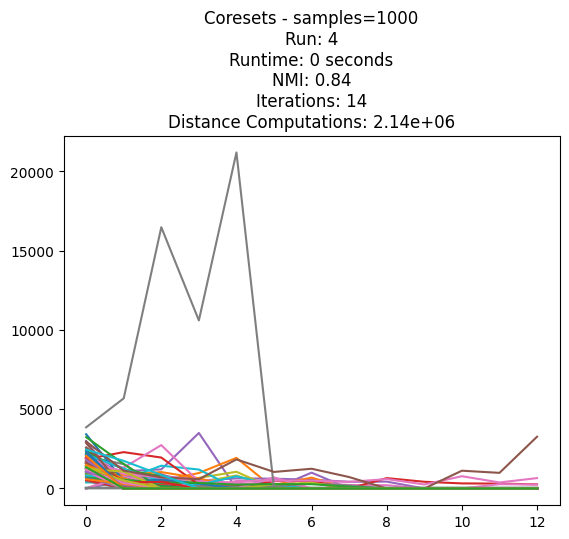

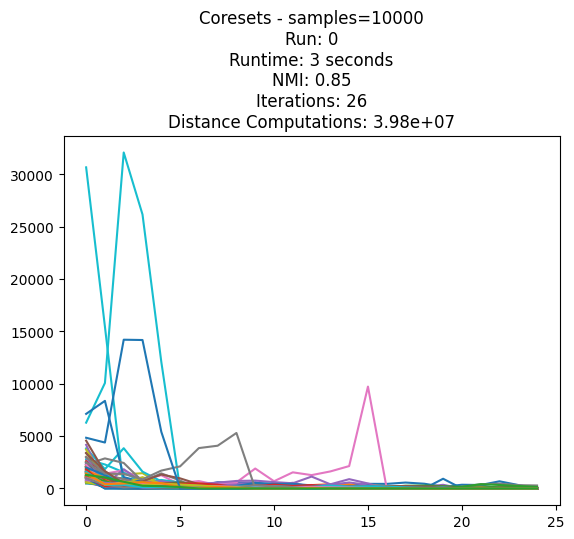

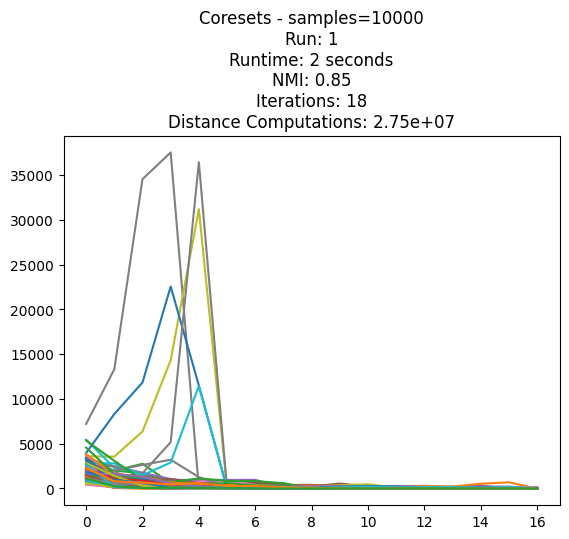

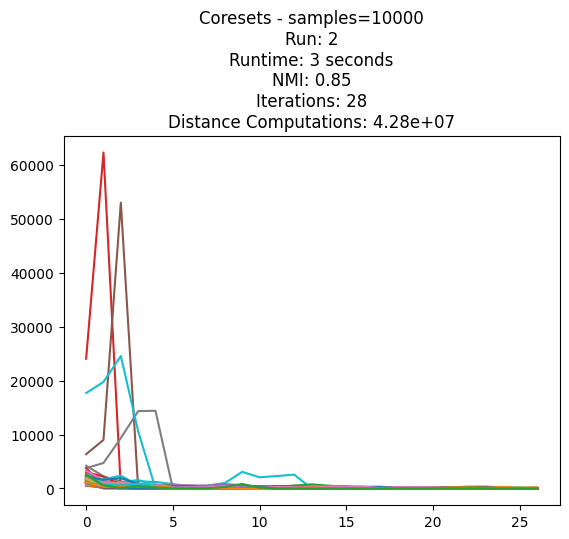

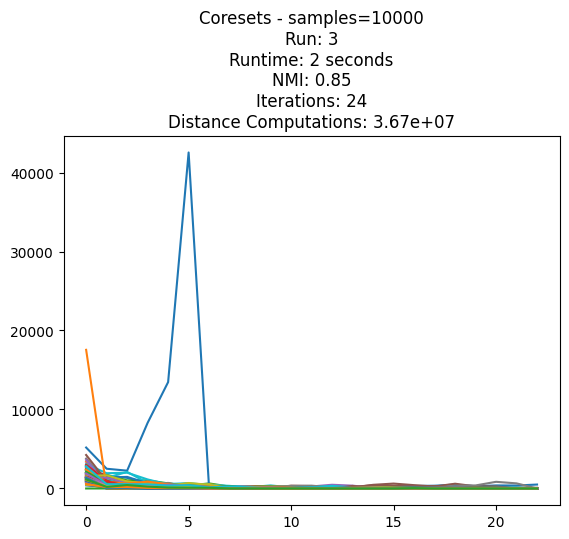

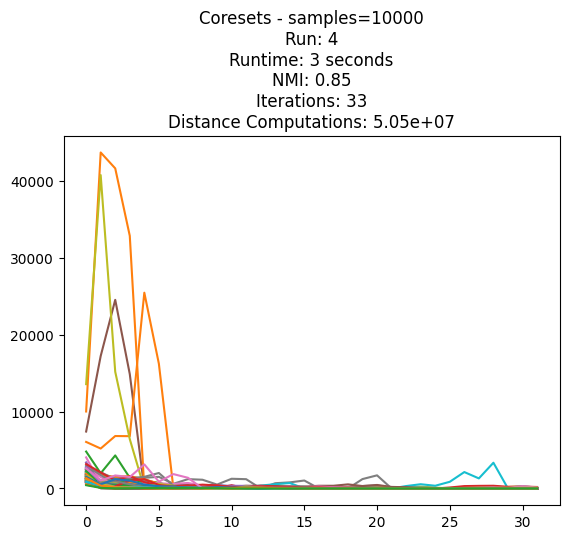

In [5]:
for samples in 200, 1_000, 10_000:
    coresets_title = f'Coresets - samples={samples}'
    report[coresets_title] = benchmark(X, y, k, runs, max_iter, atol, method='coresets', title=coresets_title, samples=samples)


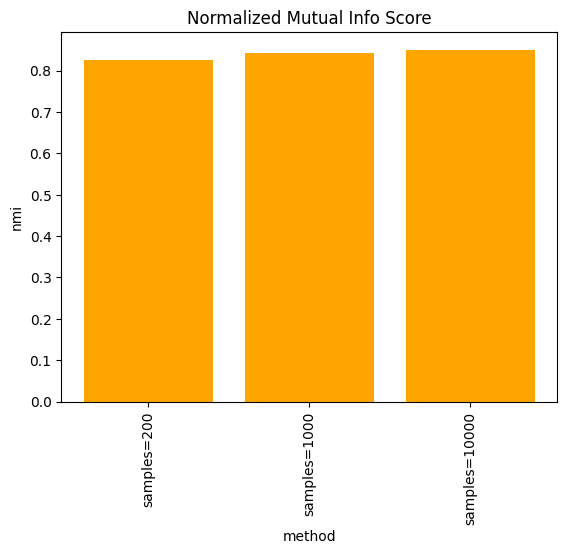

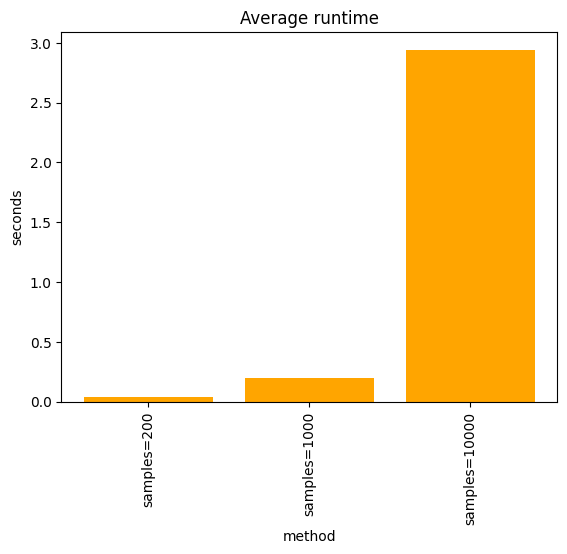

In [6]:
report_plot(report)


In [7]:
from pprint import pprint
pprint(report)

{'Coresets - samples=1000': (0.8397586920831616, 0.0),
 'Coresets - samples=10000': (0.8512494089674186, 0.8),
 'Coresets - samples=200': (0.8210845988542175, 0.0)}
